In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime                        
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization
import statsmodels.formula.api as smf              # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                      # some useful functions
from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from mlxtend.regressor import LinearRegression

In [2]:
INFLUX_DB_IP = '10.12.97.178'
INFLUX_DB_PORT = 8086
INFLUX_DB = 'demoDb'
TARGET_MEASUREMENT = 'EM_main_new'

con_obj = InfluxDBClient(host=INFLUX_DB_IP, port=INFLUX_DB_PORT, database=INFLUX_DB)
query = 'select "EM_TOTAL_Import_Energy(kWh)", "DeviceID", "time" from ' + TARGET_MEASUREMENT + ' where time > now() - 16d '
df1 = pd.DataFrame(con_obj.query(query).get_points())
df1['time'] = df1['time'].astype('datetime64[ns]')

In [3]:
date_old = (pd.datetime.now().date() - pd.offsets.Day(15))
date_now = pd.datetime.now().date() - pd.offsets.Day(0)
df2 = df1[(df1['time'] >= date_old) & (df1['time'] < date_now)]
df2 = df2[['time', 'EM_TOTAL_Import_Energy(kWh)','DeviceID']]

In [4]:
pd.datetime.now().date() - pd.offsets.Day(1)

Timestamp('2020-06-29 00:00:00')

In [5]:
df3 = df2.copy()
df3 = df3.set_index("time")
print(df3.index.min())
print(df3.index.max())

2020-06-15 01:04:19.266747
2020-06-29 23:59:59.973937


In [6]:
df2.head(2)

,time,EM_TOTAL_Import_Energy(kWh),DeviceID
104656,2020-06-15 01:04:19.266747,44062.1,EM22
104657,2020-06-15 01:04:19.447483,77285.3,EM23


In [7]:
df2.tail(2)

,time,EM_TOTAL_Import_Energy(kWh),DeviceID
4392842,2020-06-29 23:59:59.209764,44871.1,EM22
4392843,2020-06-29 23:59:59.973937,4973.0,EM3


In [8]:
class half_an_hour_min_energy:  
    
    def difference(self,df2):
        diff = []
        for g,i in df2.groupby(pd.Grouper(freq ='B',key ='time'))['EM_TOTAL_Import_Energy(kWh)']:
            try:
                diff.append([g,i.iloc[-1]-i.iloc[0]])
            except:
                diff.append([g,np.nan])
        x=pd.DataFrame(diff)
        return x        
                
    def output(self, df2):
            y = df2.groupby('DeviceID').apply(self.difference)
            y = y.pivot_table(index = 0,columns ='DeviceID',values = 1).reset_index()
            y.columns.name = None
            y = y.rename(columns = {0: ""})
            y = y.set_index("")
            y = y.fillna(0)
            return y

In [9]:
cat = half_an_hour_min_energy()
df = cat.output(df2)
df.head(2)

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
,,,,,,,,,,,,
2020-06-15,22620.0,924.0,0.0,75.9,1007.9,0.0,6069.0,6998.0,12.7,1.0,1639.2,1009.9
2020-06-16,19064.0,811.8,0.0,43.7,735.0,0.0,5361.0,6074.0,4.6,1.1,657.4,707.5


In [10]:
EM4 = df[['EM4']]
EM4.head(10)

,EM4
,
2020-06-15,6069.0
2020-06-16,5361.0
2020-06-17,6369.0
2020-06-18,6481.0
2020-06-19,12079.0
2020-06-22,4520.0
2020-06-23,5836.0
2020-06-24,5943.0
2020-06-25,6555.0


In [68]:
len(EM4)

11

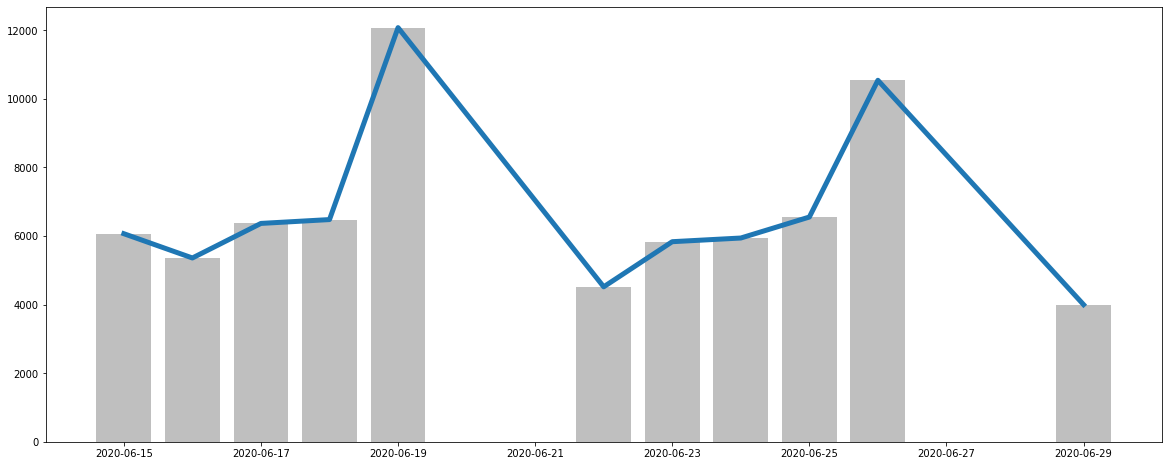

In [69]:
EM4['Date'] = [d.date() for d in EM4.index]
fig, ax1 = plt.subplots(figsize = (20,8)) 
ax1.plot(EM4['EM4'], lw = 5) 
ax1.bar(EM4["Date"], EM4["EM4"], label = 'first bar', alpha=0.5, color='gray')
ax1.grid(b=False)

In [141]:
from statsmodels.tsa.stattools import adfuller
result_o = adfuller(EM4['EM4'])
print('ADF Statistic: %f' % result_o[0])
print('p-value: %f' % result_o[1])
print('Critical Values:')
for key, value in result_o[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.712088
p-value: 0.000080
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844


In [71]:
EM4.iloc[9]

EM4          10543
Date    2020-06-26
Name: 2020-06-26 00:00:00, dtype: object

In [93]:
#Creating train and test set 
#Index 446 marks 24th June 2020 16:00
train = EM4[0:10] 
test = EM4[9:]

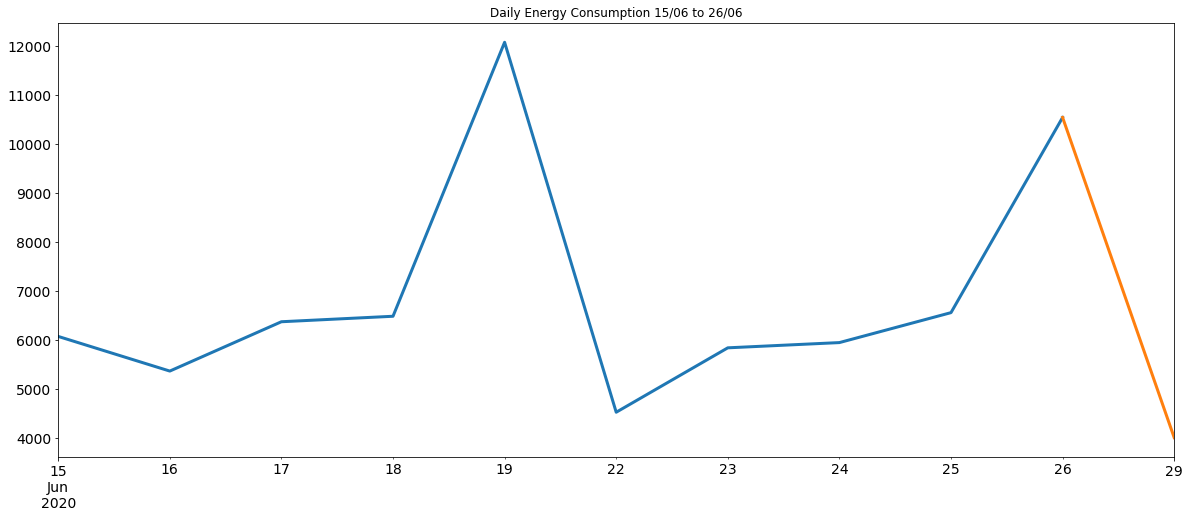

In [94]:
# Let’s visualize the data (train and test together) to know how it varies over a time period.
# Plotting data
train.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
test.EM4.plot(figsize=(20,8), title= 'Daily Energy Consumption 15/06 to 26/06', fontsize=14, lw = 3)
plt.show()

# Method 1 – Simple average

- We can infer from the graph that the price of the coin is increasing and decreasing randomly by a small margin, such that the average remains constant. Many a times we are provided with a dataset, which though varies by a small margin throughout it’s time period, but the average at each time period remains constant. In such a case we can forecast the price of the next day somewhere similar to the average of all the past days.

- Such forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

- We take all the values previously known, calculate the average and take it as the next value. Of course it won’t be it exact, but somewhat close.

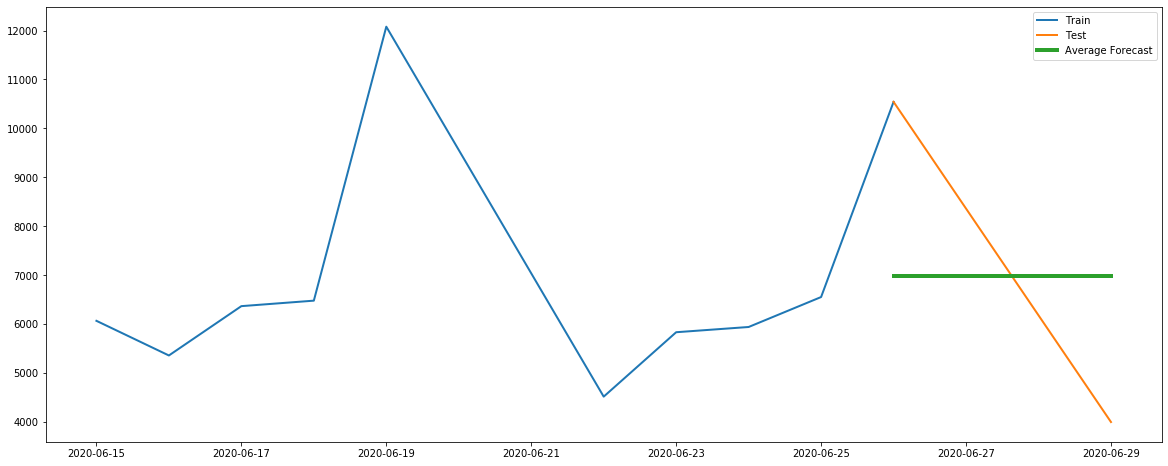

In [95]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['EM4'].mean()
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label = 'Train', lw = 2)
plt.plot(test['EM4'], label = 'Test', lw = 2)
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast', lw = 4)
plt.legend(loc = 'best')
plt.show()

In [96]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.avg_forecast))
print(rms)

3284.4016136885575


We can see that this model didn’t improve our score. 
Hence we can infer from the score that this method works best when the average at each time period remains constant.

# Method 2 – Single Exponential smoothing

- Both Simple average and Weighted moving average lie on completely opposite ends. We would need something between these two extremes approaches which takes into account all the data while weighing the data points differently. For example it may be sensible to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing.

- Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations.

- The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α.

- So essentially we’ve got a weighted moving average with two weights: α and 1−α.
As we can see, 1−α is multiplied by the previous expected value ŷ x−1 which makes the expression recursive. And this is why this method is called Exponential. The forecast at time t+1 is equal to a weighted average between the most recent observation yt and the most recent forecast ŷ t|t−1.

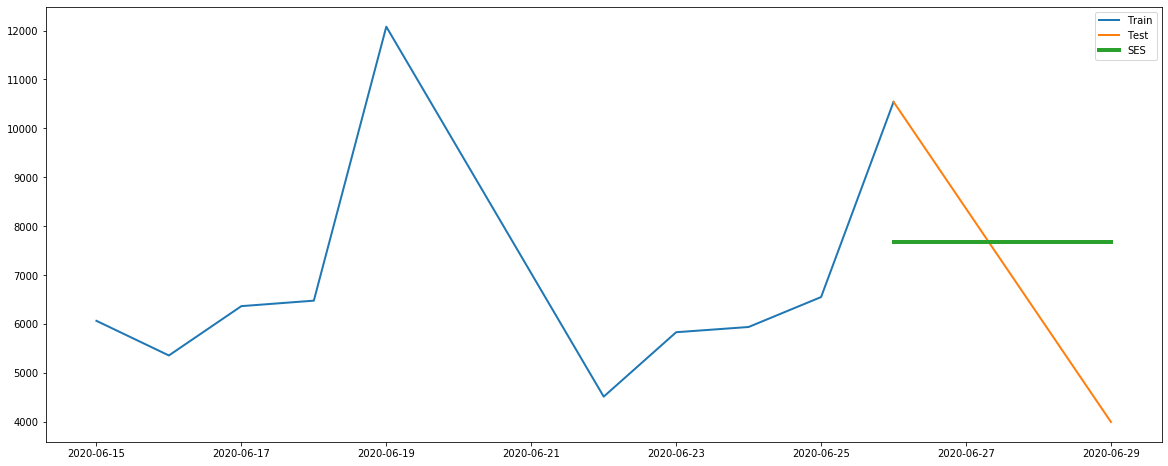

In [105]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['EM4'])).fit(smoothing_level = 0.3, optimized = False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot(train['EM4'], label='Train', lw =2)
plt.plot(test['EM4'], label='Test', lw =2)
plt.plot(y_hat_avg['SES'], label='SES', lw = 4)
plt.legend(loc='best')
plt.show()

In [106]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.SES))
print(rms)

3295.357724163421


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. We can tune the parameter using the validation set to generate even a better Simple exponential model.

# Method 3 – Holt’s Winter seasonal method

C:\Users\u23e02\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


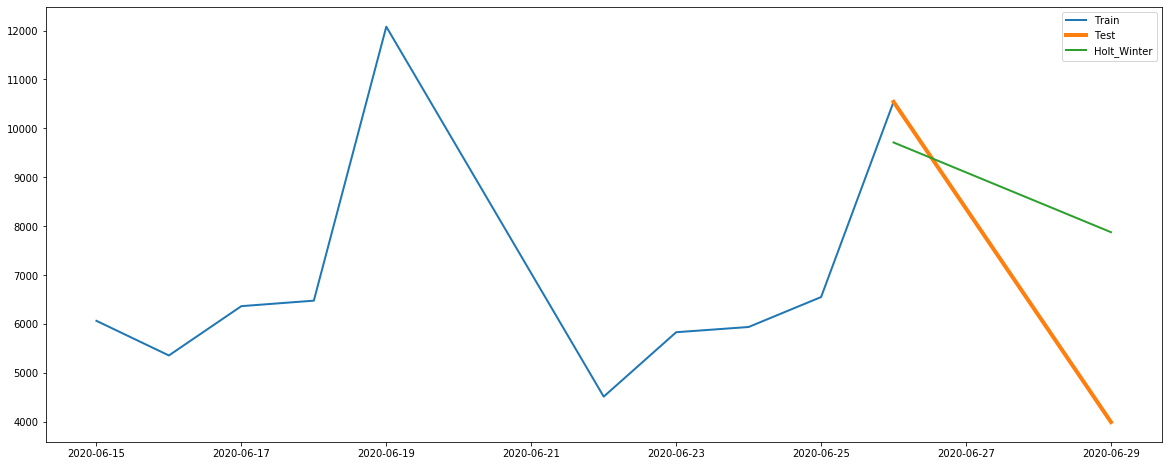

In [119]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['EM4']) ,seasonal_periods = 3, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(20,8))
plt.plot( train['EM4'], label='Train', lw = 2)
plt.plot(test['EM4'], label='Test', lw = 4)
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter', lw = 2)
plt.legend(loc='best')
plt.show()

In [120]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_Winter))
print(rms)

2805.0757810838854
